### Build a simple MLP VAE model for MNIST and freyface
**作者**: `蒋羽`
**日期**: `2025-09-20`

**参考项目**：https://github.com/pytorch/examples/tree/main/vae

**目标**: 快速实现并对比两种VAE模型。
- **MNIST**: 二元似然 (BCE Loss)。
- **Frey Face**: 高斯似然 (MSE Loss)。
- **可视化**: 随机采样10个样本，展示 `原始图 (X)`, `重建图 (X')`, `残差 (|X-X'|)`.

#### 1. 导入库

In [10]:
import os
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.utils import save_image
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import math

#### 2. 环境与参数设置

In [11]:
# --- 参数配置 ---
CONFIG = {
    "batch_size": 128, "epochs_mnist": 10, "epochs_frey": 250,
    "lr": 1e-3, "seed": 1,
}

# --- 环境设置 ---
torch.manual_seed(CONFIG["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs('results_mnist', exist_ok=True)
os.makedirs('results_freyface', exist_ok=True)

#### 3. 模型与损失函数定义

In [12]:
# --- VAE 模型定义 ---
class VAE_Binary(nn.Module): # For MNIST
    def __init__(self, z_dim=4):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(784, 400), nn.ReLU())
        self.fc_mu, self.fc_logvar = nn.Linear(400, z_dim), nn.Linear(400, z_dim)
        self.decoder_net = nn.Sequential(nn.Linear(z_dim, 400), nn.ReLU(), nn.Linear(400, 784), nn.Sigmoid())

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder_net(z)

    def forward(self, x):
        h = self.encoder(x.view(-1, 784))
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

class VAE_Gaussian(nn.Module): # For Frey Face
    def __init__(self, z_dim=4):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(560, 200), nn.ReLU())
        self.fc_mu, self.fc_logvar = nn.Linear(200, z_dim), nn.Linear(200, z_dim)
        
        self.decoder_shared = nn.Sequential(nn.Linear(z_dim, 200), nn.ReLU())
        self.decoder_mean = nn.Linear(200, 560)
        self.decoder_logvar = nn.Linear(200, 560)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h_decoded = self.decoder_shared(z)
        return self.decoder_mean(h_decoded)

    def forward(self, x):
        h = self.encoder(x.view(-1, 560))
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        h_decoded = self.decoder_shared(z)
        recon_mean = self.decoder_mean(h_decoded)
        recon_logvar = self.decoder_logvar(h_decoded)
        return (recon_mean, recon_logvar), mu, logvar

# --- 损失函数定义 ---
def loss_function_bce(recon_x, x, mu, logvar, beta=1.0):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

def loss_function_gaussian(recon_x_mean, recon_x_logvar, x, mu, logvar, beta=1.0):
    recon_loss = 0.5 * torch.sum(
        math.log(2 * math.pi) + recon_x_logvar + torch.pow(x.view(-1, 560) - recon_x_mean, 2) / torch.exp(recon_x_logvar)
    )
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * KLD

#### 4. MNIST 数据加载与训练

In [13]:
# --- 数据加载 ---
mnist_train_loader = DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=CONFIG['batch_size'], shuffle=True)
mnist_test_loader = DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=CONFIG['batch_size'], shuffle=True) # Shuffle for random sampling

# --- 模型训练 ---
model_mnist = VAE_Binary().to(device)
optimizer_mnist = optim.Adam(model_mnist.parameters(), lr=CONFIG['lr'])
print("--- Training VAE on MNIST ---")
for epoch in range(1, CONFIG['epochs_mnist'] + 1):
    model_mnist.train()
    for data, _ in mnist_train_loader:
        data = data.to(device)
        optimizer_mnist.zero_grad()
        recon_batch, mu, logvar = model_mnist(data)
        loss = loss_function_bce(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer_mnist.step()
    print(f'Epoch: {epoch}, Loss: {loss.item() / len(data):.4f}')

--- Training VAE on MNIST ---
Epoch: 1, Loss: 148.8028
Epoch: 2, Loss: 138.8019
Epoch: 3, Loss: 139.9208
Epoch: 4, Loss: 141.4578
Epoch: 5, Loss: 134.1265
Epoch: 6, Loss: 131.8034
Epoch: 7, Loss: 136.4201
Epoch: 8, Loss: 129.7505
Epoch: 9, Loss: 131.3781
Epoch: 10, Loss: 132.7116


#### 5. Frey Face 数据加载与训练

In [14]:
# --- 数据加载 ---
frey_faces = loadmat("frey_rawface.mat")["ff"].T.astype('float32') / 255.0
frey_dataset = TensorDataset(torch.from_numpy(frey_faces))
frey_loader = DataLoader(frey_dataset, batch_size=CONFIG['batch_size'], shuffle=True)

# --- 模型训练 ---
model_frey = VAE_Gaussian().to(device)
optimizer_frey = optim.Adam(model_frey.parameters(), lr=CONFIG['lr'])
print("\n--- Training VAE on Frey Face ---")

for epoch in range(1, CONFIG['epochs_frey'] + 1):
    model_frey.train()
    total_loss = 0
    for data, in frey_loader:
        data = data.to(device)
        optimizer_frey.zero_grad()
        # Unpack the mean and log-variance from the model output
        (recon_mean, recon_logvar), mu, logvar = model_frey(data)
        loss = loss_function_gaussian(recon_mean, recon_logvar, data, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer_frey.step()
    
    if epoch % 10 == 0 or epoch == CONFIG['epochs_frey']:
        avg_loss = total_loss / len(frey_loader.dataset)
        print(f'Epoch: {epoch}, Average Loss: {avg_loss:.4f}')


--- Training VAE on Frey Face ---
Epoch: 10, Average Loss: -631.2800
Epoch: 20, Average Loss: -689.3318
Epoch: 30, Average Loss: -809.4492
Epoch: 40, Average Loss: -837.8026
Epoch: 50, Average Loss: -864.3205
Epoch: 60, Average Loss: -882.4225
Epoch: 70, Average Loss: -897.0065
Epoch: 80, Average Loss: -898.5815
Epoch: 90, Average Loss: -902.6055
Epoch: 100, Average Loss: -925.1606
Epoch: 110, Average Loss: -932.8455
Epoch: 120, Average Loss: -941.9274
Epoch: 130, Average Loss: -957.6841
Epoch: 140, Average Loss: -936.0057
Epoch: 150, Average Loss: -967.3633
Epoch: 160, Average Loss: -977.2397
Epoch: 170, Average Loss: -964.2508
Epoch: 180, Average Loss: -980.2914
Epoch: 190, Average Loss: -993.2945
Epoch: 200, Average Loss: -994.5980
Epoch: 210, Average Loss: -997.6076
Epoch: 220, Average Loss: -981.6480
Epoch: 230, Average Loss: -1005.2525
Epoch: 240, Average Loss: -1002.0880
Epoch: 250, Average Loss: -1003.1438


#### 6. 可视化

Saved MNIST reconstruction comparison to 'results_mnist/reconstruction.png'
Saved Frey Face reconstruction comparison to 'results_freyface/reconstruction.png'

Top: Original, Middle: Reconstructed, Bottom: Residual


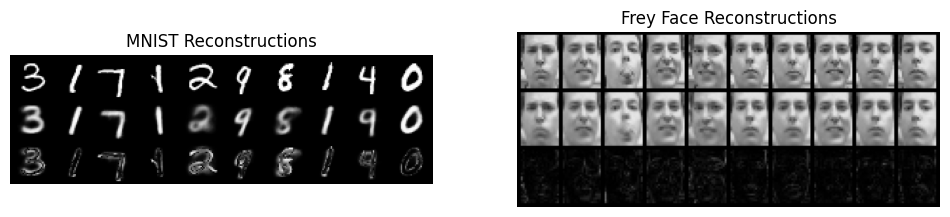

In [15]:
model_mnist.eval()
model_frey.eval()

# MNIST 结果可视化
data_batch, _ = next(iter(mnist_test_loader))
samples_X = data_batch[:10].to(device)
recon_X, _, _ = model_mnist(samples_X)
recon_X_reshaped = recon_X.view(10, 1, 28, 28)
residual = torch.abs(samples_X - recon_X_reshaped)
comparison = torch.cat([samples_X, recon_X_reshaped, residual])
save_image(comparison.cpu(), 'results_mnist/reconstruction.png', nrow=10)
print("Saved MNIST reconstruction comparison to 'results_mnist/reconstruction.png'")

# Frey Face 结果可视化
data_batch, = next(iter(frey_loader))
samples_X = data_batch[:10].to(device)
# Unpack the mean from the model output for visualization
(recon_X_mean, _), _, _ = model_frey(samples_X)
img_shape = (28, 20)
recon_X_reshaped = recon_X_mean.view(10, 1, *img_shape)
samples_X_reshaped = samples_X.view(10, 1, *img_shape)
residual = torch.abs(samples_X_reshaped - recon_X_reshaped)
comparison = torch.cat([samples_X_reshaped, recon_X_reshaped, residual])
save_image(comparison.cpu(), 'results_freyface/reconstruction.png', nrow=10)
print("Saved Frey Face reconstruction comparison to 'results_freyface/reconstruction.png'")

# Display results in notebook
print("\nTop: Original, Middle: Reconstructed, Bottom: Residual")
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(plt.imread('results_mnist/reconstruction.png'))
axes[0].set_title('MNIST Reconstructions')
axes[0].axis('off')
axes[1].imshow(plt.imread('results_freyface/reconstruction.png'))
axes[1].set_title('Frey Face Reconstructions')
axes[1].axis('off')
plt.show()

Saved generated MNIST samples to 'results_mnist/generated_samples.png'
Saved generated Frey Face samples to 'results_freyface/generated_samples.png'


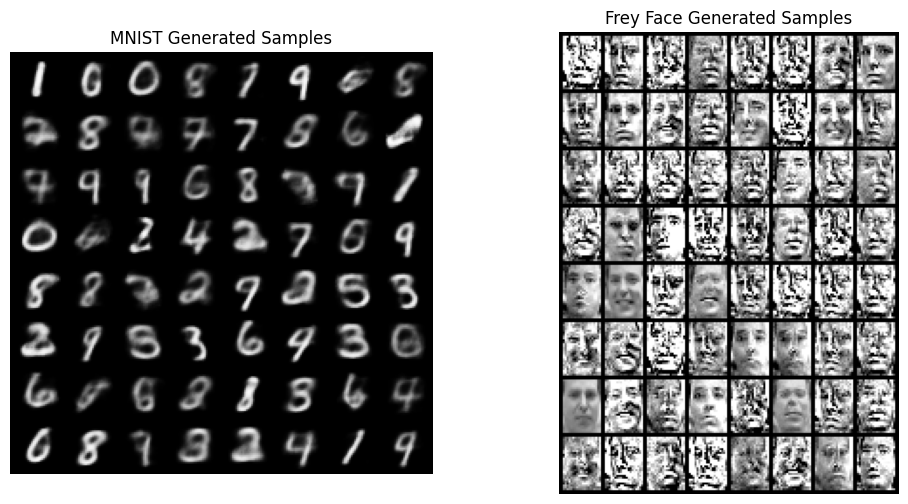

In [ ]:
# visualizing generated samples
with torch.no_grad():
    # MNIST generated samples
    z_dim_mnist = 4
    sample_z = torch.randn(64, z_dim_mnist).to(device)
    generated_mnist = model_mnist.decode(sample_z).cpu()
    save_image(generated_mnist.view(64, 1, 28, 28), 'results_mnist/generated_samples.png')
    print("Saved generated MNIST samples to 'results_mnist/generated_samples.png'")
    
    # Frey Face generated samples
    z_dim_frey = 4
    sample_z = torch.randn(64, z_dim_frey).to(device)
    # Use the mean of the decoded output for generating images and clamp for visualization
    generated_frey = torch.clamp(model_frey.decode(sample_z), 0, 1).cpu()
    save_image(generated_frey.view(64, 1, 28, 20), 'results_freyface/generated_samples.png')
    print("Saved generated Frey Face samples to 'results_freyface/generated_samples.png'")

# Display generated samples in notebook
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(plt.imread('results_mnist/generated_samples.png'))
axes[0].set_title('MNIST Generated Samples')
axes[0].axis('off')
axes[1].imshow(plt.imread('results_freyface/generated_samples.png'))
axes[1].set_title('Frey Face Generated Samples')
axes[1].axis('off')
plt.show()